In [1]:
# Helpful packages for working with images and factorizations
# using Pkg; Pkg.add("Images")
# using Pkg; Pkg.add("ImageMagick") # And this allows us to load JPEG-encoded images
using Images, LinearAlgebra, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13801447719767953028\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6699406215986222932\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13801447719767953028\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Using a SVD to compress an image

Using a singular value decomposition (SVD) to compress an image -- so that we can store an image without keeping around "unnecessary" information.

To start, let's define a singular value decomposition. In a SVD, we take a matrix $A$ and factorize it so that

$$A = USV^T$$

where matrices $U$ and $V$ are unitary and hold our singular vectors. Matrix $S$ is diagonal and stores our singular values in decreasing order from top/left to bottom/right.

In Julia, our images are stored as arrays, so we can think of our `image` variable as a matrix

In [2]:
file = download("https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg")

"C:\\Users\\akshu\\AppData\\Local\\Temp\\jl_i2TnjfQHsZ"

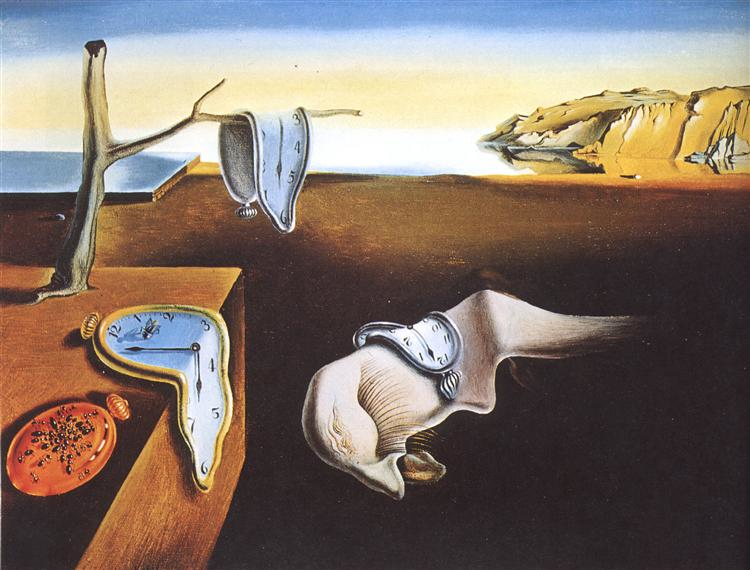

In [3]:
img = load(file)

In [19]:
typeof(img)

Array{RGB{Normed{UInt8,8}},2}

In [4]:
save("img.jpg", img)
size(img)

(570, 750)

In [5]:
img[24,24] # Each element in the array is a color

In [6]:
dump(img[24,24])

RGB{Normed{UInt8,8}}
  r: Normed{UInt8,8}
    i: UInt8 0x8a
  g: Normed{UInt8,8}
    i: UInt8 0xa4
  b: Normed{UInt8,8}
    i: UInt8 0xc5


We can extract each "channel" of red, green, and blue and view each independently:

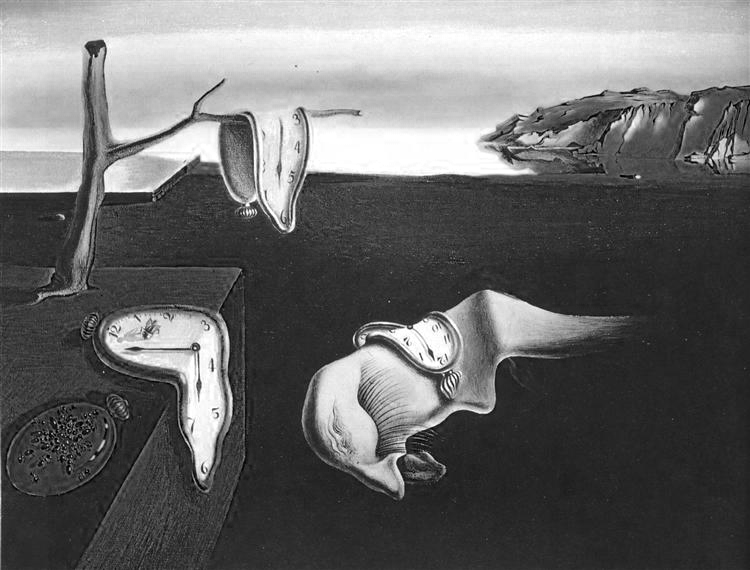

In [7]:
channels = Float64.(channelview(img))
Gray.(channels[3, :, :])

That means we can take the SVD of this image. So, we can store this picture of a banana as sets of singular vectors and singular values.

**The reason this is important** is that we'll find that we do **not** need to keep track of *all* the singular vectors and *all* the singular values to store an image that still looks exactly like the original image! This means we can choose to keep only the important information, throw away the rest, and thereby "compress" the image.

If we don't throw away any data, we get back what we started with:

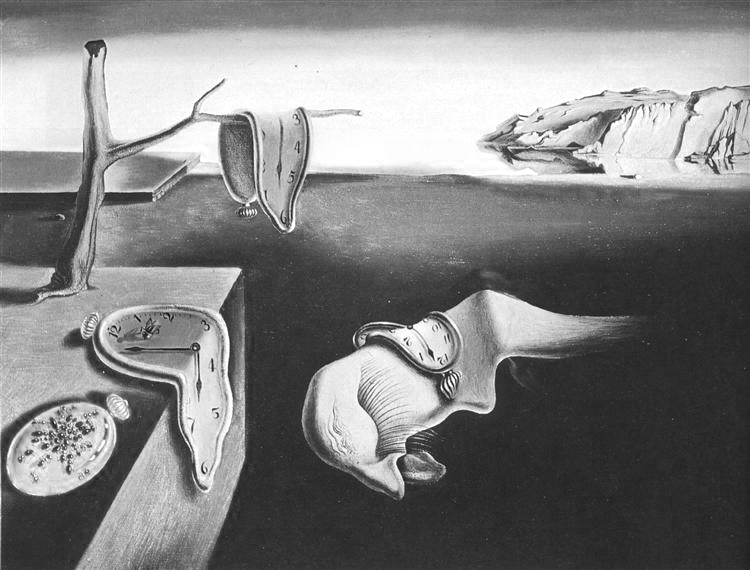

In [8]:
U, S, V = svd(channels[1,:,:])
Gray.(U * Diagonal(S) * V')

But of course we're not doing any compression here — the sizes of U, S, and V are bigger than our original matrix! This is like the opposite of compression.  The key is that the values are stored in decreasing order so we can start throwing things away.

In [9]:
sum(length.((U, S, V)))

752970

In [10]:
length(img)

427500

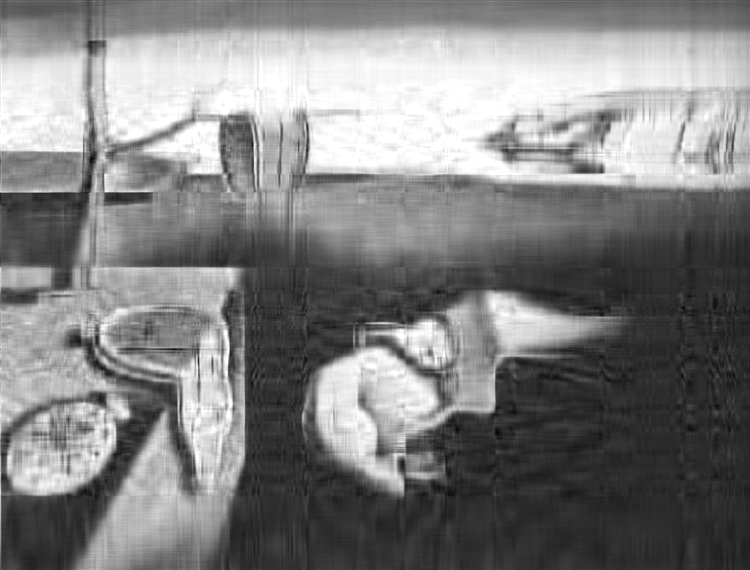

In [11]:
Gray.(U[:, 1:25] * Diagonal(S[1:25]) * V[:, 1:25]')

In [12]:
sum(length.((U[:, 1:25], S[1:25], V[:, 1:25])))/length(img)

0.0772514619883041

Of course this is just one channel of the image. Let's put it all back together and see how we can compress the different channels to find an acceptable compression level.

In [13]:
function rank_approx(M, k)
    U, S, V = svd(M)
    
    M = U[:, 1:k] * Diagonal(S[1:k]) * V[:, 1:k]'
    
    M = min.(max.(M, 0.0), 1.)
end

n = 100
@manipulate for k1 in 1:n, k2 in 1:n, k3 in 1:n
    colorview(  RGB, 
                rank_approx(channels[1,:,:], k1),
                rank_approx(channels[2,:,:], k2),
                rank_approx(channels[3,:,:], k3)
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["k1"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
50, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\akshu\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\akshu\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000027ee30f0, Task (runnable) @0x0000000027ee30f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

**Finally**

putting it all togather

In [30]:
function compress_image(img, factor)
#     channels = Float64.(channelview(img))
    channels = channelview(img)
    
    rows, cols = size(img)
    
    img_svd = [svd(channels[i, :, :]) for i ∈ 1:3]

    U, S, V = [img_svd[i].U for i ∈ 1:3], [img_svd[i].S for i ∈ 1:3], [img_svd[i].V for i ∈ 1:3]

    num_sv = size(S[1])[1]
    use_sv = fld(num_sv, factor) # `fld` returns an integer

    compressed_image = [U[i][:, 1:use_sv] * Diagonal(S[i][1:use_sv]) * V[i][:, 1:use_sv]' for i ∈ 1:3]

    [RGB(compressed_image[1][i, j], compressed_image[2][i, j], compressed_image[3][i, j]) for i=1:rows, j=1:cols]
end

compress_image (generic function with 1 method)

  1.331626 seconds (106 allocations: 37.061 MiB)


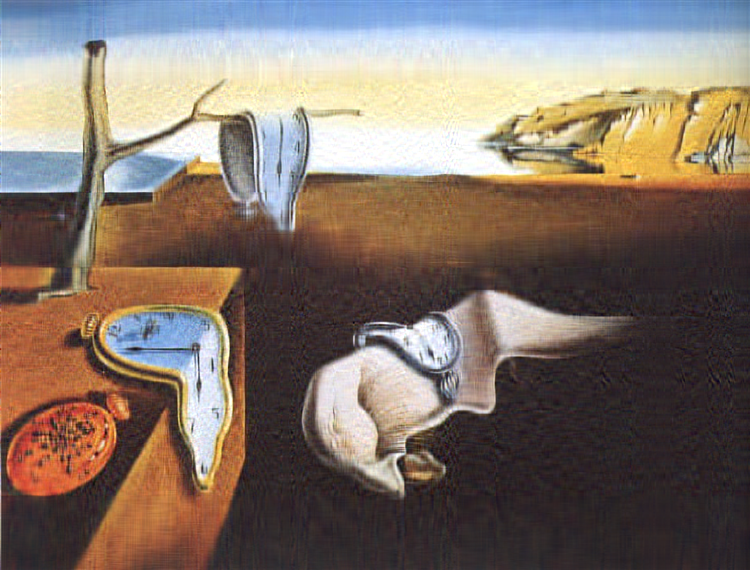

In [33]:
@time compressed_img = compress_image(img, 10)

In [34]:
typeof(compressed_img)

Array{RGB{Float32},2}

In [35]:
save("compressed_img.png", compressed_img)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\akshu\.julia\packages\ImageMagick\Cq1Ef\src\ImageMagick.jl:180


623042